# Analysis from Brian Goggin (uses newly-produced data as of September 2017)

In [32]:
import pandas as pd
import logging
import dateutil
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [33]:
#import dataset of project times from "data" folder
file = "../../../data/cleaned/all_quarters__one_record_per_project.csv"
df = pd.read_csv(file)

In [34]:
#First, filter out those projects that are exclusively non-residential (defined as those without units)
df = df[df['units'] > 0]

In [35]:
#Next, keep only those that reached completion at some point over the time period
df=df[pd.notnull(df['comp_date'])]

In [36]:
df.shape

(943, 24)

In [37]:
#drop duplicates for now, until manual cleaning is done
df= df[~ df.duplicated('dbi_permit', keep=False)]

In [38]:
df.shape

(868, 24)

In [5]:
df.head()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y
0,25696,2015-05-13,259 CLARA ST,3753042,2016-04-22,CONSTRUCTION,10/01/2016,2016-04-22,2.01305E+11,2013-05-16,2013-05-16,2013-05-16,2016-04-22,CONSTRUCTION,"('2013-05-16', '2013-05-16', '2013-05-16', '20...",1234.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",3,2016,Under Construction,8.0,8.0,37.778347,-122.403506
8,29014,NaN,6044 GEARY BL,1456023,2016-11-29,CONSTRUCTION,04/01/2017,2016-06-16,2.01409E+11,2014-09-05,2016-06-16,NaN,2016-11-29,CONSTRUCTION,"('2016-06-16', '2016-08-26', '2016-11-29', '20...",939.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2017,Under Construction,3.0,3.0,37.780413,-122.484482
12,4754,NaN,1671 11TH AV,1932012,2006-03-07,CONSTRUCTION,01/01/2011,2006-03-07,2.0031E+11,2003-10-10,2006-03-07,2003-10-10,2006-03-07,CONSTRUCTION,"('2006-03-07', '2006-03-07')",2640.0,"('CONSTRUCTION', 'CONSTRUCTION')",4,2010,Under Construction,2.0,NaN,-122.468152,37.757083
20,11125,NaN,4227 LINCOLN WY,1707047,2008-03-25,CONSTRUCTION,04/01/2013,2008-03-25,200306207365,2003-06-20,2008-03-25,2003-06-20,2008-03-25,CONSTRUCTION,"('2008-03-25', '2008-03-25', '2008-03-25', '20...",3573.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2013,Under Construction,1.0,1.0,37.764167,-122.503298
31,2303,NaN,539 FAXON AV,6934002,2009-07-15,CONSTRUCTION,04/01/2010,2009-07-15,2.00705E+11,2007-05-22,2009-07-15,2007-05-22,2009-07-15,CONSTRUCTION,"('2009-07-15', '2009-07-15', '2009-07-15')",1045.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION')",1,2010,Under Construction,1.0,NaN,-122.460415,37.724102


In [39]:
#convert completion date to date variables type
df['project_duration_days'].describe()

count     868.000000
mean     1624.794931
std      1106.771928
min         1.000000
25%       782.750000
50%      1349.500000
75%      2224.750000
max      8807.000000
Name: project_duration_days, dtype: float64

In [40]:
df['project_time_years']=df['project_duration_days']/365

In [41]:
df['project_time_years'].describe()

count    868.000000
mean       4.451493
std        3.032252
min        0.002740
25%        2.144521
50%        3.697260
75%        6.095205
max       24.128767
Name: project_time_years, dtype: float64

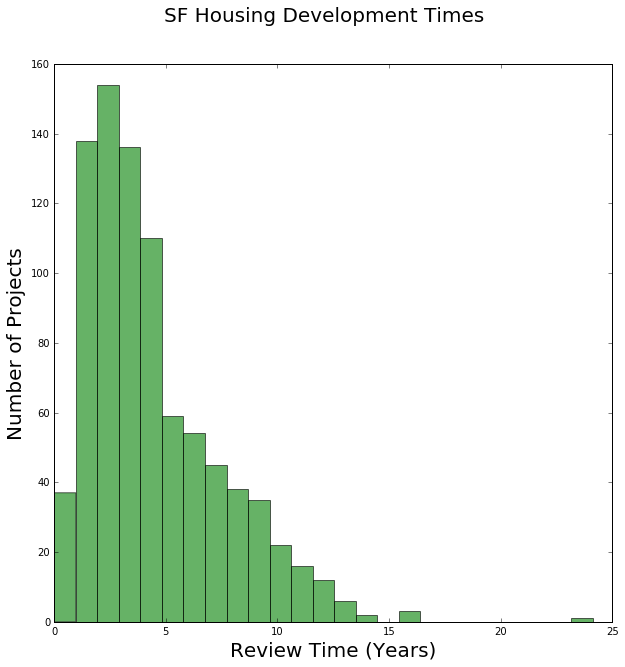

In [42]:
plt.figure(1, figsize=(10,10), )
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.xlabel('Review Time (Years)', fontsize = 20)
plt.ylabel('Number of Projects', fontsize = 20)
ax = plt.hist(df['project_time_years'], bins=25, alpha=.6, color='g')
plt.savefig('../../../hitogram.png')
plt.show()

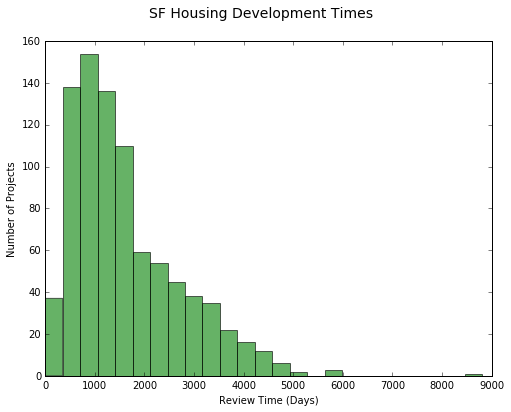

In [43]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('SF Housing Development Times', fontsize=14)
plt.xlabel('Review Time (Days)')
plt.ylabel('Number of Projects')
ax = plt.hist(df['project_duration_days'], bins=25, alpha=.6, color='g')
plt.show()

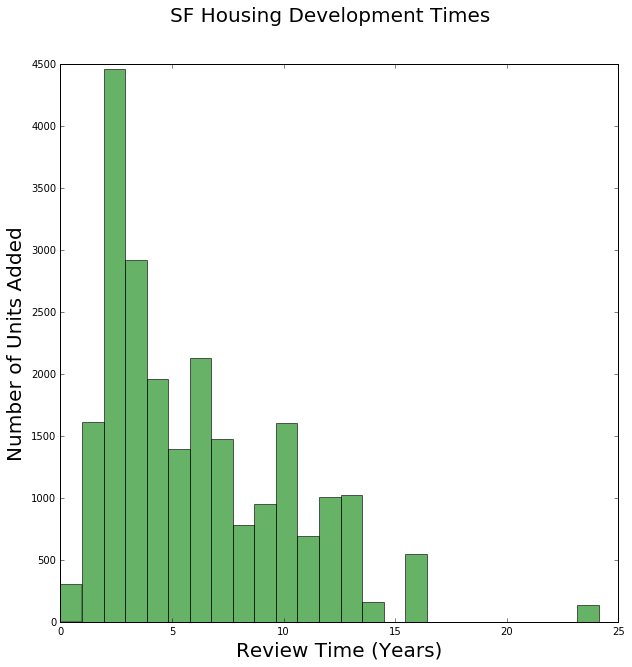

In [44]:
#Create dataset of net units added with 
list = []
uniqueid = 0
for index, row in df.iterrows():
    amount = int(row['units'])
    for units in range(0, amount):
        dictionary = {}
        dictionary['id']=uniqueid+1
        dictionary['time']=row['project_time_years']
        list.append(dictionary)
        uniqueid=uniqueid+1
df_units = pd.DataFrame(list)

plt.figure(1, figsize=(10,10), )
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.xlabel('Review Time (Years)', fontsize = 20)
plt.ylabel('Number of Units Added', fontsize = 20)
ax = plt.hist(df_units['time'], bins=25, alpha=.6, color='g')
plt.savefig('../../../hitogram2.png')
plt.show()

In [66]:
def unit_categories(value):
    if value['units'] <10:
        field = '0-10'
    elif (value['units'] >=10) & (value['units'] <50):
        field = '10-50'
    elif (value['units']>= 50) & (value['units'] <100):
        field = '50-100'
    elif (value['units']>= 100) & (value['units'] <500):
        field = '100-500'
    elif value['units']>500:
        field = '>500'
    return field
    
df['unitcat']=df.apply(unit_categories, axis=1)

In [73]:
cat_medians=[]
categories=['0-10', '10-50', '50-100', '100-500', '>500']
for cat in categories:
    median = df[df['unitcat']==cat]['project_duration_days'].median()
    cat_medians.append(median)

In [82]:
objects = ('0-10', '10-50', '50-100', '100-500', '>500')
y_pos = np.arange(len(objects))

In [83]:
y_pos

array([0, 1, 2, 3, 4])

In [91]:
for cat in categories:
    print (df[df['unitcat']==cat]['address'].count())

666
91
47
60
4


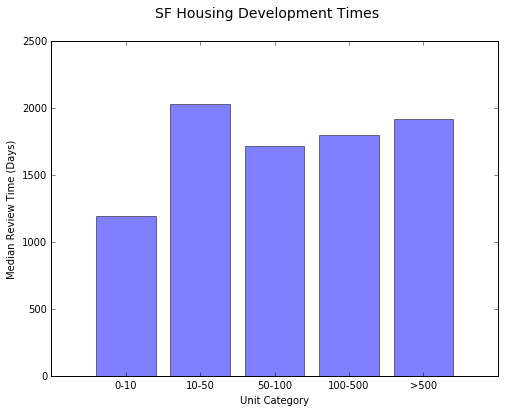

In [87]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('SF Housing Development Times', fontsize=14)
plt.ylabel('Median Review Time (Days)')
plt.xlabel('Unit Category')
plt.bar(y_pos, cat_medians, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.show()

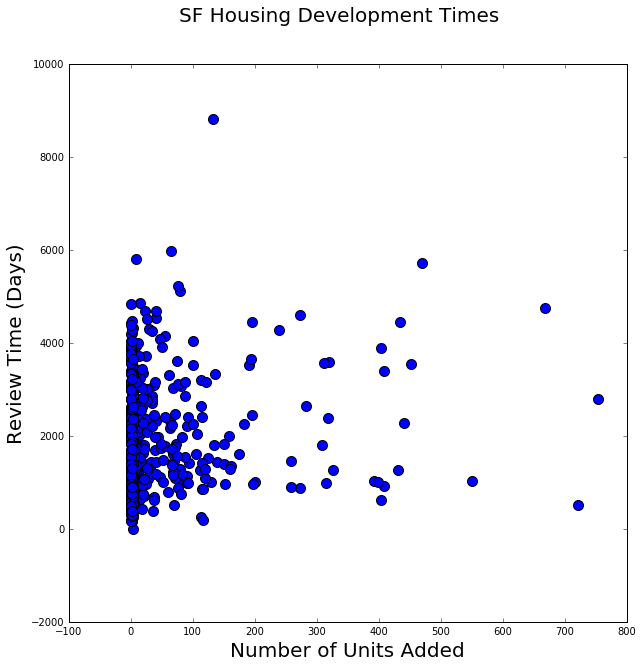

In [45]:
plt.figure(1, figsize=(10,10))
plt.scatter(df['units'], df['project_duration_days'], s=100)
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.ylabel('Review Time (Days)', fontsize = 20)
plt.xlabel('Number of Units Added', fontsize = 20)
plt.savefig('../../../scatter.png')

In [16]:
# Top 5 longest projects
df.sort_values('project_time_years', ascending = False)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,project_time_years
102,18560,NaN,833-881 JAMESTOWN,4991277,2007-09-17,CONSTRUCTION,04/01/2015,2007-09-17,9924080S,1991-02-19,2007-09-17,1991-02-19,2007-09-17,CONSTRUCTION,"('2007-09-17', '2007-09-17', '2007-09-17', '20...",8807.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2015,Under Construction,132.0,14.0,37.717174,-122.392222,24.128767
1954,26437,NaN,POTRERO1010 (BLDG 1 OF 2),3833001,2016-05-26,CONSTRUCTION,10/01/2016,2016-05-26,2.01112E+11,2000-05-18,2016-05-26,2000-05-18,2016-05-26,CONSTRUCTION,"('2016-05-26', '2016-05-26')",5980.0,"('CONSTRUCTION', 'CONSTRUCTION')",3,2016,Under Construction,65.0,65.0,37.767108,-122.396595,16.383562
409,17247,2008-11-07,1179 TENNESSEE ST,4172053,2014-12-18,CONSTRUCTION,01/01/2015,2014-03-21,9902819.0,1999-02-11,2008-11-07,2001-04-26,2014-12-18,CONSTRUCTION,"('2008-11-07', '2009-11-03', '2009-11-03', '20...",5803.0,"('BP REINSTATED', 'BP REINSTATED', 'BP REINSTA...",4,2014,Under Construction,8.0,8.0,37.755993,-122.389058,15.898630
2132,21263,2012-09-07,1000 16TH ST,3833001,2015-12-24,CONSTRUCTION,01/01/2016,2012-09-07,201112070227.0,2000-05-18,2012-07-13,2000-05-18,2015-12-24,CONSTRUCTION,"('2012-07-13', '2012-07-13', '2012-07-13', '20...",5706.0,"('PL APPROVED', 'PL APPROVED', 'PL APPROVED', ...",4,2015,Under Construction,470.0,470.0,37.767108,-122.396595,15.632877
2103,24161,NaN,1634 - 1690 PINE ST,0647007,2016-07-01,CONSTRUCTION,07/01/2016,2016-01-14,201312000000.0,2000-11-27,2016-01-14,2000-11-27,2016-07-01,CONSTRUCTION,"('2016-01-14', '2016-03-29', '2016-07-01')",5695.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION')",2,2016,Under Construction,260.0,260.0,37.789593,-122.422951,15.602740


In [48]:
# Top 5 longest projects
df.sort_values('project_time_years', ascending = True)[0:20]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,project_time_years
1784,19261,NaN,270 CAPITOL AV,7113065,2015-06-30,CONSTRUCTION,07/01/2015,2015-06-30,201303041387.0,2015-06-30,2015-06-30,NaN,2015-06-30,CONSTRUCTION,"('2015-06-30',)",1.0,"('CONSTRUCTION',)",2,2015,Under Construction,4.0,4.0,37.712755,-122.458787,0.002740
2542,2346,NaN,850 30TH AV,1672024,2010-02-24,CONSTRUCTION,04/01/2010,2010-02-24,200910269851,2009-10-26,2009-10-26,2009-10-26,2010-02-24,CONSTRUCTION,"('2009-10-26', '2010-02-24')",157.0,"('BP FILED', 'CONSTRUCTION')",1,2010,Under Construction,2.0,NaN,-122.489282,37.773244,0.430137
3121,19463,NaN,526 HICKORY ST,0829040,2015-01-21,CONSTRUCTION,07/01/2015,2015-01-21,201209200264.0,2015-01-21,2015-01-21,NaN,2015-01-21,CONSTRUCTION,"('2015-01-21',)",161.0,"('CONSTRUCTION',)",2,2015,Under Construction,1.0,1.0,37.774845,-122.428663,0.441096
2166,21046,NaN,414 SOMERSET ST,6044003,2015-10-05,CONSTRUCTION,10/01/2015,2015-10-05,201504103396.0,2015-04-10,2015-04-10,2015-04-10,2015-10-05,CONSTRUCTION,"('2015-04-10', '2015-10-05')",174.0,"('BP FILED', 'CONSTRUCTION')",3,2015,Under Construction,2.0,1.0,37.726252,-122.407649,0.476712
2460,10897,2012-10-26,55 05TH ST,3705039,2012-12-12,CONSTRUCTION,01/01/2013,2012-12-12,201206202986,2012-06-20,2012-06-20,2012-06-20,2012-12-12,CONSTRUCTION,"('2012-06-20', '2012-10-26', '2012-12-12')",195.0,"('BP FILED', 'BP APPROVED', 'CONSTRUCTION')",4,2012,Under Construction,116.0,8.0,37.783461,-122.407185,0.534247
2180,10900,2012-10-23,28 PRECITA AV,5518023,2012-11-15,CONSTRUCTION,01/01/2013,2012-11-15,201206203050,2012-06-20,2012-06-20,2012-06-20,2012-11-15,CONSTRUCTION,"('2012-06-20', '2012-10-23', '2012-11-15')",195.0,"('BP FILED', 'BP ISSUED', 'CONSTRUCTION')",4,2012,Under Construction,2.0,1.0,37.746472,-122.418489,0.534247
2840,656,NaN,64 14TH ST,3529017,2009-08-07,CONSTRUCTION,10/01/2009,2009-08-07,200903194471,2009-03-19,2009-08-07,2009-03-19,2009-08-07,CONSTRUCTION,"('2009-08-07',)",196.0,"('CONSTRUCTION',)",3,2009,Under Construction,1.0,-1.0,-122.414942,37.768706,0.536986
214,4588,NaN,290 FARALLONES ST,7105015,2011-01-11,CONSTRUCTION,01/01/2011,2011-01-11,201006033737,2010-06-03,2010-06-03,2010-06-03,2011-01-11,CONSTRUCTION,"('2010-06-03', '2010-06-03', '2011-01-11')",212.0,"('BP FILED', 'BP FILED', 'CONSTRUCTION')",4,2010,Under Construction,2.0,NaN,-122.462430,37.714286,0.580822
461,29090,NaN,71 CURTIS ST,6464037,2017-03-02,CONSTRUCTION,04/01/2017,2017-03-02,201608266121,2016-08-26,2016-08-26,NaN,2017-03-02,CONSTRUCTION,"('2016-08-26', '2016-08-26', '2017-03-02')",218.0,"('BP FILED', 'BP FILED', 'CONSTRUCTION')",1,2017,Under Construction,2.0,1.0,37.713630,-122.439396,0.597260
1997,18801,NaN,352 WALLER ST,0859013,2015-03-06,CONSTRUCTION,04/01/2015,2015-03-06,201408214409.0,2014-08-21,2014-08-21,NaN,2015-03-06,CONSTRUCTION,"('2014-08-21', '2015-03-06', '2015-03-06')",223.0,"('BP FILED', 'CONSTRUCTION', 'CONSTRUCTION')",1,2015,Under Construction,2.0,1.0,37.771555,-122.429516,0.610959


In [17]:
df.head()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,project_time_years
1,8574,NaN,350 LINDEN ST,0817069,2014-01-17,CONSTRUCTION,10/01/2014,2013-07-12,200710185839,2007-10-18,2013-07-12,2007-10-18,2014-01-17,CONSTRUCTION,"('2013-07-12', '2013-07-12', '2014-01-17', '20...",2540.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",3,2014,Under Construction,6.0,6.0,37.776427,-122.423498,6.958904
3,5396,NaN,1844 MARKET ST,0871016,2013-08-26,CONSTRUCTION,10/01/2013,2007-07-17,200607146588,2005-06-01 07:00:00,2007-07-17,2005-06-01,2013-08-26,CONSTRUCTION,"('2007-07-17', '2007-07-17', '2007-07-17', '20...",3043.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",3,2013,Under Construction,113.0,113.0,37.771461,-122.424688,8.336986
4,7405,2013-06-18,2401 16TH ST,3965001,2014-06-30,CONSTRUCTION,07/01/2014,2013-12-10,201208248160,2008-10-09 07:00:00,2011-04-21,2008-10-09,2014-06-30,CONSTRUCTION,"('2011-04-21', '2011-04-21', '2012-08-24', '20...",2090.0,"('PL APPROVED', 'PL APPROVED', 'BP FILED', 'BP...",2,2014,Under Construction,12.0,12.0,37.765523,-122.410614,5.726027
7,13704,2012-09-24,551 22ND AV,1565006A,2016-01-11,CONSTRUCTION,01/01/2016,2014-05-22,201012025978.0,2010-12-02,2010-12-02,2010-12-02,2016-01-11,CONSTRUCTION,"('2010-12-02', '2010-12-02', '2012-09-24', '20...",1856.0,"('BP FILED', 'BP FILED', 'BP APPROVED', 'BP AP...",4,2015,Under Construction,2.0,2.0,37.777328,-122.481640,5.084932
12,13540,2012-11-26,200 COLEMAN ST,4591C098,2016-01-07,CONSTRUCTION,01/01/2016,2014-06-23,200912223674.0,2009-12-22,2012-11-26,2009-12-22,2016-01-07,CONSTRUCTION,"('2012-11-26', '2012-11-26', '2012-11-26', '20...",2201.0,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'CONST...",4,2015,Under Construction,12.0,12.0,37.727648,-122.368909,6.030137


In [17]:
df['unitsnet'].sum()

27641.0

In [23]:
df.shape

(943, 25)

In [ ]:
#do graph of bar graph categories are (unit size (e.g. 10-25)) and y axis is median time to completion